In [1]:
# training the model

In [2]:
# generally all the modules needed
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import h5py
import numpy as np
import torchvision.transforms.functional as TF
import optuna
import random
from sklearn.metrics import classification_report, roc_auc_score 
from joblib import Parallel, delayed
import cv2
import glob
from optuna.importance import get_param_importances
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from torch.utils.data import WeightedRandomSampler
import gc

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False     

set_seed(42)

## Building and Training the model

The idea is to put the data into data loaders, define a flexible structured CNN, define a loss function, define a objective function, and use optuna to optimize the structure of the CNN. 

Due to the data being limited in the number of positive cases, the training of the model was targeted to best handle this. This included:
- Using only a training and validation set to maximize the number of positive cases the model could learn from
- a focal loss function to put emphasis on not missing positives
- using both a weighted sampler in the Dataloader and a high positive weight in the training 

In [4]:
class PatchTensorDataset(Dataset):
    def __init__(self, chunk_dir):
        self.data = []
        self.counter = 0

        paths = sorted([
            os.path.join(chunk_dir, f) 
            for f in os.listdir(chunk_dir) 
            if f.startswith('chunk') and f.endswith('.pt')
        ])
        for path in paths:
            self.data.extend(torch.load(path))
        print("initialized")

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        sample = self.data[idx]
        self.counter += 1
        return sample['data'], sample['label'], sample['filename'], sample['patch_id']


dataset = PatchTensorDataset("/explore/nobackup/people/cemeehan")

all_labels = [int(dataset[i][1]) for i in range(len(dataset))]

# compute class counts and weights
class_counts = np.bincount(all_labels)
class_weights = 1.0 / class_counts
sample_weights = [class_weights[label] for label in all_labels]

sampler = WeightedRandomSampler(weights = sample_weights, num_samples = len(sample_weights), replacement = True)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=32, sampler = sampler, shuffle = False, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle = False, num_workers=2, pin_memory=True, persistent_workers=True)

initialized


In [5]:
class FeaturePresenceCNN(nn.Module):
    def __init__(self, num_layers=2, kernel_size=3, base_channels=16, dropout=0.0):
        super().__init__()
        layers = []
        in_channels = 6
        kernel_size = int(kernel_size)
        for i in range(num_layers):
            out_channels = base_channels * (2 ** i)
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_channels = out_channels
 
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_channels, 1)
        )
 
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [1]:
def objective(trial):

    num_gpus = torch.cuda.device_count()
    gpu_id = trial.number % num_gpus if num_gpus > 0 else None
    device = torch.device(f"cuda:{gpu_id}" if num_gpus > 0 else "cpu")


    set_seed(42)

    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0
    patience = 5

    # Suggest hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    base_channels = 16
    pos_weight_val = trial.suggest_float("pos_weight", 1.0, 100.0, log=True)
    num_layers = trial.suggest_int("num_layers", 1, 5)
    kernel_size = trial.suggest_int("kernel_size", 3, 5)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)

    # Model setup
    model = FeaturePresenceCNN(
        num_layers=num_layers,
        kernel_size=kernel_size,
        base_channels=base_channels,
        dropout=dropout
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    pos_weight = torch.tensor([class_counts[0] / class_counts[1]]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for epoch in range(30):
        model.train()
        total_train_loss = 0

        for inputs, labels, filenames, patch_ids in train_loader:
            inputs = inputs.to(device)
            labels = labels.view(-1, 1).float().to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels, filenames, patch_ids in val_loader:
                inputs = inputs.to(device)
                labels = labels.view(-1, 1).float().to(device)

                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

                all_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        all_probs = np.array(all_preds)
        all_labels_bin = np.array(all_labels).astype(int)

        # 🔸 Original metrics at threshold = 0.5
        all_preds_bin = (all_probs > 0.5).astype(int)
        val_acc = (all_preds_bin == all_labels_bin).mean()

        print(f"Epoch {epoch + 1} | Train loss: {total_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(classification_report(all_labels_bin, all_preds_bin, digits=4))
        print("AUROC:", roc_auc_score(all_labels_bin, all_probs))

        trial.report(avg_val_loss, step=epoch)

        # Optuna pruning check
        if trial.should_prune():
            raise optuna.TrialPruned()

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Stopping early after {epoch + 1} epochs (no improvement in {patience} epochs).")
                break

    # Save best model
    if best_model_state is not None:
        torch.save(best_model_state, f"model_trial_{trial.number}.pt")

    # Cleanup
    del model, optimizer, criterion, best_model_state
    torch.cuda.empty_cache()
    gc.collect()

    return roc_auc_score(all_labels_bin, all_probs)  # can be switched to optimize for the loss 

In [23]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed = 42))
study.optimize(objective, n_trials=15,  n_jobs=1)

# print("Best trial:")
# print(study.best_trial.params)

print("Best trial:")
print(study.best_trial.params)
print("Best value:", study.best_value)
print(f"Load model from model_trial_{study.best_trial.number}.pt")

best_trial_num = study.best_trial.number
import shutil
shutil.copyfile(f"model_trial_{best_trial_num}.pt", "final_model_auc.pt")
print(f"Saved best model as final_model.pt from trial {best_trial_num}")

# Analyze:
importances = get_param_importances(study)
print(importances)
torch.save(importances, "parameter_values.pt")

[I 2025-08-02 21:05:51,248] A new study created in memory with name: no-name-66246fa9-4000-4604-a407-838f5033c557


Epoch 1 | Train loss: 9964.8688 | Val Loss: 1.6859, Val Acc: 0.0387
              precision    recall  f1-score   support

           0     1.0000    0.0292    0.0567      3841
           1     0.0101    1.0000    0.0200        38

    accuracy                         0.0387      3879
   macro avg     0.5050    0.5146    0.0383      3879
weighted avg     0.9903    0.0387    0.0563      3879

AUROC: 0.6549692377259211
Epoch 2 | Train loss: 2840.9107 | Val Loss: 1.4880, Val Acc: 0.3779
              precision    recall  f1-score   support

           0     0.9945    0.3739    0.5434      3841
           1     0.0123    0.7895    0.0243        38

    accuracy                         0.3779      3879
   macro avg     0.5034    0.5817    0.2838      3879
weighted avg     0.9848    0.3779    0.5383      3879

AUROC: 0.6795859082749832
Epoch 3 | Train loss: 3271.5436 | Val Loss: 1.2814, Val Acc: 0.9276
              precision    recall  f1-score   support

           0     0.9939    0.9326  

/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 8 | Train loss: 2696.1062 | Val Loss: 2.7785, Val Acc: 0.9835
              precision    recall  f1-score   support

           0     0.9906    0.9927    0.9917      3841
           1     0.0667    0.0526    0.0588        38

    accuracy                         0.9835      3879
   macro avg     0.5287    0.5227    0.5253      3879
weighted avg     0.9816    0.9835    0.9825      3879

AUROC: 0.6720152372600338
Stopping early after 8 epochs (no improvement in 5 epochs).


[I 2025-08-02 21:13:33,281] Trial 0 finished with value: 0.6720152372600338 and parameters: {'lr': 5.6115164153345e-05, 'weight_decay': 0.006351221010640704, 'batch_size': 16, 'pos_weight': 2.0511104188433973, 'num_layers': 1, 'kernel_size': 5, 'dropout': 0.3005575058716044}. Best is trial 0 with value: 0.6720152372600338.


Epoch 1 | Train loss: 5387.6440 | Val Loss: 2.8522, Val Acc: 0.9897
              precision    recall  f1-score   support

           0     0.9905    0.9992    0.9948      3841
           1     0.2500    0.0263    0.0476        38

    accuracy                         0.9897      3879
   macro avg     0.6202    0.5128    0.5212      3879
weighted avg     0.9832    0.9897    0.9855      3879

AUROC: 0.6597103276284959
Epoch 2 | Train loss: 3860.6771 | Val Loss: 1.2045, Val Acc: 0.7327
              precision    recall  f1-score   support

           0     0.9930    0.7352    0.8449      3841
           1     0.0174    0.4737    0.0336        38

    accuracy                         0.7327      3879
   macro avg     0.5052    0.6045    0.4392      3879
weighted avg     0.9834    0.7327    0.8369      3879

AUROC: 0.6893489908055742
Epoch 3 | Train loss: 2730.9204 | Val Loss: 4.0038, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000  

/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 4 | Train loss: 3778.3179 | Val Loss: 1.2539, Val Acc: 0.9513
              precision    recall  f1-score   support

           0     0.9938    0.9568    0.9749      3841
           1     0.0829    0.3947    0.1370        38

    accuracy                         0.9513      3879
   macro avg     0.5383    0.6758    0.5560      3879
weighted avg     0.9849    0.9513    0.9667      3879

AUROC: 0.7027158497650008
Epoch 5 | Train loss: 2830.9905 | Val Loss: 1.3881, Val Acc: 0.4591
              precision    recall  f1-score   support

           0     0.9938    0.4567    0.6258      3841
           1     0.0128    0.7105    0.0251        38

    accuracy                         0.4591      3879
   macro avg     0.5033    0.5836    0.3254      3879
weighted avg     0.9842    0.4591    0.6199      3879

AUROC: 0.6994409350635115
Epoch 6 | Train loss: 2662.5486 | Val Loss: 2.0512, Val Acc: 0.2310
              precision    recall  f1-score   support

           0     0.9977    0.2239  

[I 2025-08-02 21:19:33,700] Trial 1 finished with value: 0.7417750311733512 and parameters: {'lr': 0.0002607024758370766, 'weight_decay': 1.2087541473056965e-06, 'batch_size': 16, 'pos_weight': 2.310201887845293, 'num_layers': 1, 'kernel_size': 3, 'dropout': 0.2623782158161189}. Best is trial 1 with value: 0.7417750311733512.


Epoch 1 | Train loss: 3932.7819 | Val Loss: 1.1251, Val Acc: 0.8791
              precision    recall  f1-score   support

           0     0.9947    0.8826    0.9353      3841
           1     0.0425    0.5263    0.0786        38

    accuracy                         0.8791      3879
   macro avg     0.5186    0.7044    0.5069      3879
weighted avg     0.9854    0.8791    0.9269      3879

AUROC: 0.7845476095863193
Epoch 2 | Train loss: 1420.6070 | Val Loss: 1.0489, Val Acc: 0.4432
              precision    recall  f1-score   support

           0     1.0000    0.4376    0.6088      3841
           1     0.0173    1.0000    0.0340        38

    accuracy                         0.4432      3879
   macro avg     0.5086    0.7188    0.3214      3879
weighted avg     0.9904    0.4432    0.6032      3879

AUROC: 0.9059935049808849
Epoch 3 | Train loss: 1205.2147 | Val Loss: 0.9744, Val Acc: 0.8244
              precision    recall  f1-score   support

           0     0.9984    0.8240  

[I 2025-08-02 21:53:56,838] Trial 2 finished with value: 0.9355156962961948 and parameters: {'lr': 7.309539835912905e-05, 'weight_decay': 1.461896279370496e-05, 'batch_size': 16, 'pos_weight': 5.404103854647328, 'num_layers': 3, 'kernel_size': 5, 'dropout': 0.09983689107917987}. Best is trial 2 with value: 0.9355156962961948.


Epoch 1 | Train loss: 3343.8188 | Val Loss: 1.3416, Val Acc: 0.0098
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      3841
           1     0.0098    1.0000    0.0194        38

    accuracy                         0.0098      3879
   macro avg     0.0049    0.5000    0.0097      3879
weighted avg     0.0001    0.0098    0.0002      3879

AUROC: 0.3806917058331849


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 2 | Train loss: 681.6895 | Val Loss: 1.3409, Val Acc: 0.0098
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      3841
           1     0.0098    1.0000    0.0194        38

    accuracy                         0.0098      3879
   macro avg     0.0049    0.5000    0.0097      3879
weighted avg     0.0001    0.0098    0.0002      3879

AUROC: 0.4580392989764178


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 3 | Train loss: 696.9563 | Val Loss: 1.3408, Val Acc: 0.0098
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      3841
           1     0.0098    1.0000    0.0194        38

    accuracy                         0.0098      3879
   macro avg     0.0049    0.5000    0.0097      3879
weighted avg     0.0001    0.0098    0.0002      3879

AUROC: 0.44091450965346196


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 4 | Train loss: 676.3352 | Val Loss: 1.3396, Val Acc: 0.0098
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      3841
           1     0.0098    1.0000    0.0194        38

    accuracy                         0.0098      3879
   macro avg     0.0049    0.5000    0.0097      3879
weighted avg     0.0001    0.0098    0.0002      3879

AUROC: 0.667041203633922


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 5 | Train loss: 669.6627 | Val Loss: 1.3402, Val Acc: 0.9758
              precision    recall  f1-score   support

           0     0.9906    0.9849    0.9877      3841
           1     0.0333    0.0526    0.0408        38

    accuracy                         0.9758      3879
   macro avg     0.5120    0.5188    0.5143      3879
weighted avg     0.9812    0.9758    0.9785      3879

AUROC: 0.558146864166404
Epoch 6 | Train loss: 671.1458 | Val Loss: 1.3399, Val Acc: 0.9801
              precision    recall  f1-score   support

           0     0.9901    0.9898    0.9900      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9801      3879
   macro avg     0.4951    0.4949    0.4950      3879
weighted avg     0.9804    0.9801    0.9803      3879

AUROC: 0.5507817317310459
Epoch 7 | Train loss: 668.2259 | Val Loss: 1.3236, Val Acc: 0.7780
              precision    recall  f1-score   support

           0     0.9927    0.7816    0.

[I 2025-08-02 22:46:31,015] Trial 3 finished with value: 0.9457241124159005 and parameters: {'lr': 0.00010677482709481354, 'weight_decay': 0.00023423849847112912, 'batch_size': 32, 'pos_weight': 1.3492834268013245, 'num_layers': 5, 'kernel_size': 5, 'dropout': 0.40419867405823057}. Best is trial 3 with value: 0.9457241124159005.


Epoch 1 | Train loss: 11985.5010 | Val Loss: 1.3895, Val Acc: 0.1090
              precision    recall  f1-score   support

           0     1.0000    0.1002    0.1822      3841
           1     0.0109    1.0000    0.0215        38

    accuracy                         0.1090      3879
   macro avg     0.5054    0.5501    0.1019      3879
weighted avg     0.9903    0.1090    0.1806      3879

AUROC: 0.6220625111333398
Epoch 2 | Train loss: 2312.9586 | Val Loss: 1.3734, Val Acc: 0.4517
              precision    recall  f1-score   support

           0     0.9931    0.4494    0.6187      3841
           1     0.0121    0.6842    0.0239        38

    accuracy                         0.4517      3879
   macro avg     0.5026    0.5668    0.3213      3879
weighted avg     0.9835    0.4517    0.6129      3879

AUROC: 0.6759547267022019
Epoch 3 | Train loss: 3002.8841 | Val Loss: 1.5297, Val Acc: 0.0559
              precision    recall  f1-score   support

           0     1.0000    0.0466 

/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 8 | Train loss: 2208.6421 | Val Loss: 3.3905, Val Acc: 0.9894
              precision    recall  f1-score   support

           0     0.9904    0.9990    0.9947      3841
           1     0.2000    0.0263    0.0465        38

    accuracy                         0.9894      3879
   macro avg     0.5952    0.5126    0.5206      3879
weighted avg     0.9827    0.9894    0.9854      3879

AUROC: 0.6470902588415846
Epoch 9 | Train loss: 2351.7521 | Val Loss: 1.2911, Val Acc: 0.2070
              precision    recall  f1-score   support

           0     0.9961    0.1999    0.3330      3841
           1     0.0113    0.9211    0.0223        38

    accuracy                         0.2070      3879
   macro avg     0.5037    0.5605    0.1776      3879
weighted avg     0.9865    0.2070    0.3300      3879

AUROC: 0.6846832650488497
Epoch 10 | Train loss: 2346.0202 | Val Loss: 1.2051, Val Acc: 0.8520
              precision    recall  f1-score   support

           0     0.9937    0.8560 

[I 2025-08-02 23:02:53,872] Trial 4 finished with value: 0.7337384727113279 and parameters: {'lr': 4.066563313514796e-05, 'weight_decay': 2.4586032763280077e-06, 'batch_size': 16, 'pos_weight': 9.780337016659407, 'num_layers': 1, 'kernel_size': 5, 'dropout': 0.12938999080000846}. Best is trial 3 with value: 0.9457241124159005.
[I 2025-08-02 23:04:26,464] Trial 5 pruned. 


Epoch 1 | Train loss: 5198.3908 | Val Loss: 1.3407, Val Acc: 0.9897
              precision    recall  f1-score   support

           0     0.9902    0.9995    0.9948      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9897      3879
   macro avg     0.4951    0.4997    0.4974      3879
weighted avg     0.9805    0.9897    0.9851      3879

AUROC: 0.46178010112498125
Epoch 1 | Train loss: 2193.4280 | Val Loss: 19.9239, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.3029912714616534


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 2 | Train loss: 862.5219 | Val Loss: 14.9371, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.4141807917346086


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 3 | Train loss: 717.2123 | Val Loss: 10.8717, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.5681977007084229


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 4 | Train loss: 688.1239 | Val Loss: 7.9115, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.6327642198440648


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 5 | Train loss: 668.6208 | Val Loss: 6.2441, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.6646089971087573


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 6 | Train loss: 650.8999 | Val Loss: 2.6798, Val Acc: 0.9869
              precision    recall  f1-score   support

           0     0.9904    0.9964    0.9934      3841
           1     0.0667    0.0263    0.0377        38

    accuracy                         0.9869      3879
   macro avg     0.5285    0.5113    0.5156      3879
weighted avg     0.9814    0.9869    0.9840      3879

AUROC: 0.6994477863494978
Epoch 7 | Train loss: 642.5605 | Val Loss: 1.9265, Val Acc: 0.9825
              precision    recall  f1-score   support

           0     0.9911    0.9911    0.9911      3841
           1     0.1053    0.1053    0.1053        38

    accuracy                         0.9825      3879
   macro avg     0.5482    0.5482    0.5482      3879
weighted avg     0.9825    0.9825    0.9825      3879

AUROC: 0.720042752024555
Epoch 8 | Train loss: 602.2341 | Val Loss: 2.0727, Val Acc: 0.9820
              precision    recall  f1-score   support

           0     0.9911    0.9906    0.

[I 2025-08-02 23:38:46,404] Trial 6 finished with value: 0.9352210909987805 and parameters: {'lr': 0.0001569639638866114, 'weight_decay': 0.0048696409415209, 'batch_size': 32, 'pos_weight': 4.473636174621264, 'num_layers': 2, 'kernel_size': 3, 'dropout': 0.41436875457596467}. Best is trial 3 with value: 0.9457241124159005.
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

Epoch 1 | Train loss: 687.5496 | Val Loss: 1.4206, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.5387440222529769
Epoch 1 | Train loss: 11790.4052 | Val Loss: 32.3763, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.24132969758423656


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 2 | Train loss: 364.7056 | Val Loss: 31.7400, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.24258348291974405


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 3 | Train loss: 358.5994 | Val Loss: 31.3177, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.24390578111511532


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 4 | Train loss: 370.6154 | Val Loss: 30.8353, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.24503624330286794


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 5 | Train loss: 358.1200 | Val Loss: 31.7711, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.24653667493388506


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 6 | Train loss: 342.5479 | Val Loss: 31.2167, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.24733827539429148


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 7 | Train loss: 358.4320 | Val Loss: 31.1498, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.24800627577796353


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 8 | Train loss: 359.8054 | Val Loss: 31.9868, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.2494895791940147


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 9 | Train loss: 362.6991 | Val Loss: 32.0013, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.25049671823401254
Stopping early after 9 epochs (no improvement in 5 epochs).


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 1 | Train loss: 1687.6308 | Val Loss: 1.3242, Val Acc: 0.1384
              precision    recall  f1-score   support

           0     1.0000    0.1299    0.2300      3841
           1     0.0112    1.0000    0.0222        38

    accuracy                         0.1384      3879
   macro avg     0.5056    0.5650    0.1261      3879
weighted avg     0.9903    0.1384    0.2279      3879

AUROC: 0.7535660943559106


[I 2025-08-02 23:53:33,929] Trial 10 pruned. 


Epoch 1 | Train loss: 2514.1122 | Val Loss: 1.2157, Val Acc: 0.7151
              precision    recall  f1-score   support

           0     0.9964    0.7149    0.8325      3841
           1     0.0249    0.7368    0.0482        38

    accuracy                         0.7151      3879
   macro avg     0.5107    0.7259    0.4404      3879
weighted avg     0.9869    0.7151    0.8248      3879

AUROC: 0.797407473382754
Epoch 1 | Train loss: 3082.8211 | Val Loss: 2.2138, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.6838885158744297


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 2 | Train loss: 1839.0439 | Val Loss: 1.2497, Val Acc: 0.2872
              precision    recall  f1-score   support

           0     0.9981    0.2807    0.4381      3841
           1     0.0129    0.9474    0.0254        38

    accuracy                         0.2872      3879
   macro avg     0.5055    0.6140    0.2318      3879
weighted avg     0.9885    0.2872    0.4341      3879

AUROC: 0.7338343907151372
Epoch 3 | Train loss: 1567.1373 | Val Loss: 1.5266, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.8143027446251662


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 4 | Train loss: 1484.9018 | Val Loss: 1.1403, Val Acc: 0.9740
              precision    recall  f1-score   support

           0     0.9924    0.9813    0.9868      3841
           1     0.1111    0.2368    0.1513        38

    accuracy                         0.9740      3879
   macro avg     0.5517    0.6090    0.5690      3879
weighted avg     0.9837    0.9740    0.9786      3879

AUROC: 0.8710587977363352
Epoch 5 | Train loss: 1406.3030 | Val Loss: 1.0996, Val Acc: 0.9698
              precision    recall  f1-score   support

           0     0.9936    0.9758    0.9846      3841
           1     0.1308    0.3684    0.1931        38

    accuracy                         0.9698      3879
   macro avg     0.5622    0.6721    0.5889      3879
weighted avg     0.9852    0.9698    0.9769      3879

AUROC: 0.9057948176872799
Epoch 6 | Train loss: 1287.1972 | Val Loss: 1.1031, Val Acc: 0.2758
              precision    recall  f1-score   support

           0     1.0000    0.2687  

[I 2025-08-03 00:04:59,186] Trial 11 pruned. 


Epoch 8 | Train loss: 1222.9110 | Val Loss: 0.9658, Val Acc: 0.9394
              precision    recall  f1-score   support

           0     0.9948    0.9438    0.9686      3841
           1     0.0809    0.5000    0.1392        38

    accuracy                         0.9394      3879
   macro avg     0.5378    0.7219    0.5539      3879
weighted avg     0.9858    0.9394    0.9605      3879

AUROC: 0.9253209827484619


[I 2025-08-03 00:06:09,921] Trial 12 pruned. 


Epoch 1 | Train loss: 2115.1499 | Val Loss: 1.2086, Val Acc: 0.4341
              precision    recall  f1-score   support

           0     0.9970    0.4298    0.6007      3841
           1     0.0148    0.8684    0.0292        38

    accuracy                         0.4341      3879
   macro avg     0.5059    0.6491    0.3149      3879
weighted avg     0.9874    0.4341    0.5951      3879

AUROC: 0.7122528398580413


[I 2025-08-03 00:07:45,947] Trial 13 pruned. 


Epoch 1 | Train loss: 8129.7925 | Val Loss: 1.3502, Val Acc: 0.0593
              precision    recall  f1-score   support

           0     0.9706    0.0515    0.0979      3841
           1     0.0087    0.8421    0.0172        38

    accuracy                         0.0593      3879
   macro avg     0.4896    0.4468    0.0576      3879
weighted avg     0.9612    0.0593    0.0971      3879

AUROC: 0.3686471450691295
Epoch 1 | Train loss: 4411.9843 | Val Loss: 2.8338, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.5198207703585962


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 2 | Train loss: 2031.9766 | Val Loss: 1.0465, Val Acc: 0.9172
              precision    recall  f1-score   support

           0     0.9963    0.9198    0.9565      3841
           1     0.0751    0.6579    0.1348        38

    accuracy                         0.9172      3879
   macro avg     0.5357    0.7889    0.5457      3879
weighted avg     0.9873    0.9172    0.9485      3879

AUROC: 0.8892215568862275
Epoch 3 | Train loss: 1637.8177 | Val Loss: 3.1239, Val Acc: 0.9902
              precision    recall  f1-score   support

           0     0.9902    1.0000    0.9951      3841
           1     0.0000    0.0000    0.0000        38

    accuracy                         0.9902      3879
   macro avg     0.4951    0.5000    0.4975      3879
weighted avg     0.9805    0.9902    0.9853      3879

AUROC: 0.8502445909097138


/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Epoch 4 | Train loss: 1271.8194 | Val Loss: 1.0613, Val Acc: 0.4524
              precision    recall  f1-score   support

           0     0.9994    0.4473    0.6180      3841
           1     0.0171    0.9737    0.0337        38

    accuracy                         0.4524      3879
   macro avg     0.5083    0.7105    0.3258      3879
weighted avg     0.9898    0.4524    0.6123      3879

AUROC: 0.9066306745776181
Epoch 5 | Train loss: 1185.2042 | Val Loss: 0.9672, Val Acc: 0.8850
              precision    recall  f1-score   support

           0     0.9974    0.8862    0.9385      3841
           1     0.0622    0.7632    0.1151        38

    accuracy                         0.8850      3879
   macro avg     0.5298    0.8247    0.5268      3879
weighted avg     0.9882    0.8850    0.9305      3879

AUROC: 0.9038422011811617
Epoch 6 | Train loss: 1160.7859 | Val Loss: 1.2165, Val Acc: 0.1083
              precision    recall  f1-score   support

           0     1.0000    0.0995  

[I 2025-08-03 00:40:07,960] Trial 14 finished with value: 0.9354266295783719 and parameters: {'lr': 9.09871535218999e-05, 'weight_decay': 5.066743066031341e-06, 'batch_size': 16, 'pos_weight': 1.015843234684204, 'num_layers': 2, 'kernel_size': 4, 'dropout': 0.02673769417725183}. Best is trial 3 with value: 0.9457241124159005.


Best trial:
{'lr': 0.00010677482709481354, 'weight_decay': 0.00023423849847112912, 'batch_size': 32, 'pos_weight': 1.3492834268013245, 'num_layers': 5, 'kernel_size': 5, 'dropout': 0.40419867405823057}
Best value: 0.9457241124159005
Load model from model_trial_3.pt
Saved best model as final_model.pt from trial 3
OrderedDict([('batch_size', 0.2610344658037116), ('num_layers', 0.24107601115072375), ('dropout', 0.18277882759894712), ('lr', 0.15510110255449502), ('weight_decay', 0.12166427025899791), ('pos_weight', 0.02271270214006525), ('kernel_size', 0.015632620493059354)])


In [6]:
# first load in the model and weights

model = FeaturePresenceCNN(
    num_layers=5,        # set to whatever you used
    dropout = 0.40419867405823057,
    kernel_size=5,
    base_channels=16
)
 
# Load the weights
model.load_state_dict(torch.load("/home/cemeehan/actual_stuff/final_model_auc.pt", map_location="cpu"))
model.eval()
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
 
# Load validation data
# val_loader = DataLoader(val_dataset, batch_size=32)
 
# Run inference on validation data
all_probs = []
all_labels = []
all_ids = []
all_patchid = []
 
with torch.no_grad():
    for inputs, labels, filename, patch_id in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        all_probs.extend(probs)
        all_labels.extend(labels.numpy().flatten())
        all_ids.extend(patch_id.numpy().flatten())
all_probs = np.array(all_probs)
all_labels = np.array(all_labels).astype(int)
all_ids = np.array(all_ids).astype(int)

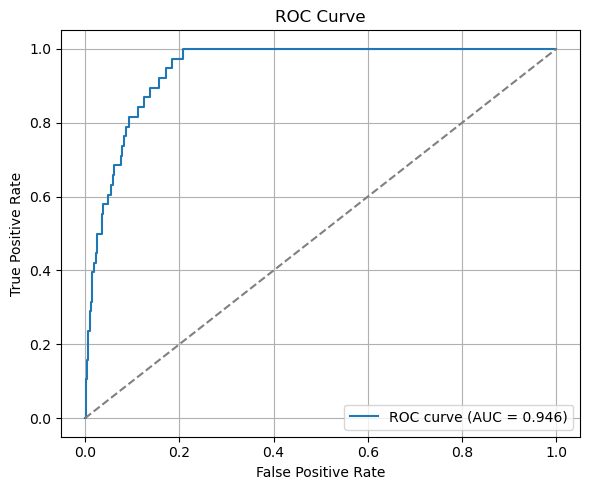

In [7]:
import matplotlib.pyplot as plt

fpr, tpr, roc_thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
%matplotlib inline

In [8]:
import matplotlib.pyplot as plt

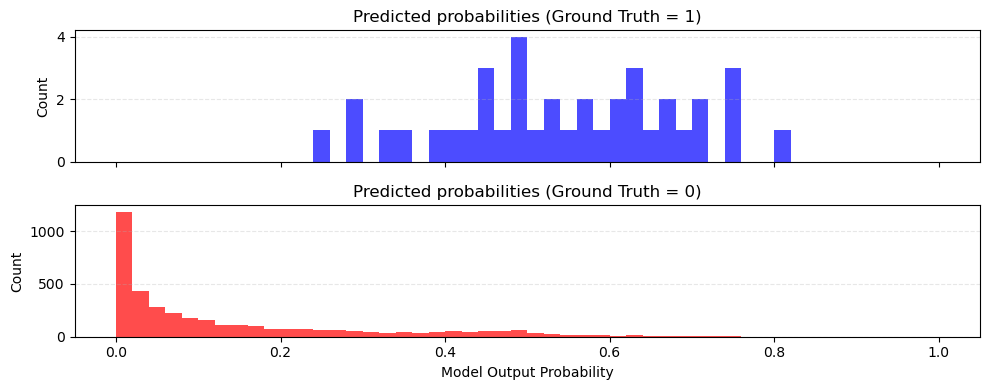

In [10]:
import numpy as np
import matplotlib.pyplot as plt

probs = np.array(all_probs).flatten()        # shape (N,)
labels = np.array(all_labels).flatten()      # shape (N,)

pos_probs = probs[labels == 1]
neg_probs = probs[labels == 0]

fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

# Histogram for Positives
axes[0].hist(pos_probs, bins=50, range=(0, 1), color='blue', alpha=0.7)
axes[0].set_title('Predicted probabilities (Ground Truth = 1)')
axes[0].set_ylabel('Count')
axes[0].grid(True, axis='y', linestyle='--', alpha=0.3)

# Histogram for Negatives
axes[1].hist(neg_probs, bins=50, range=(0, 1), color='red', alpha=0.7)
axes[1].set_title('Predicted probabilities (Ground Truth = 0)')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Model Output Probability')
axes[1].grid(True, axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


In [11]:
yes = []
maybe = []
no = []

LT = 0.2
UT = 0.8

for i in pos_probs:
    if i > 0.8:
        yes.append(i)
    elif i < 0.2:
        no.append(i)
    else:
        maybe.append(i)

for i in neg_probs:
    if i > 0.8:
        yes.append(i)
    elif i < 0.2:
        no.append(i)
    else:
        maybe.append(i)

In [12]:
print("total data points:",len(pos_probs) + len(neg_probs))
print("total positive",len(pos_probs))
print("model predicts yes",len(yes))
print("model predicts no",len(no))
print("model predicts maybe",len(maybe))
print(" ")
print("total images that don't need to be viewed",len(yes) + len(no))
print("this is", 100 * (len(yes) + len(no)) / (len(pos_probs) + len(neg_probs)))

total data points: 3879
total positive 38
model predicts yes 6
model predicts no 2864
model predicts maybe 1009
 
total images that don't need to be viewed 2870
this is 73.9881412735241


In [20]:
from collections import defaultdict

# STEP 1: Group labels by patch ID
id_to_labels = defaultdict(list)

for pid, label in zip(all_ids, all_labels):
    id_to_labels[pid].append(label)

# Find patch IDs that NEVER have label 1
always_zero_ids = {pid for pid, labels in id_to_labels.items() if all(l == 0 for l in labels)}

# STEP 2: Classify all_probs using patch IDs and thresholds
yes = []
no = []
maybe = []

LT = 0.2
UT = 0.8

for prob, pid in zip(all_probs, all_ids):
    if pid in always_zero_ids:
        no.append(prob)
    elif prob > UT:
        yes.append(prob)
    elif prob < LT:
        no.append(prob)
    else:
        maybe.append(prob)

In [21]:
print("total data points:",len(pos_probs) + len(neg_probs))
print("total positive",len(pos_probs))
print("model predicts yes",len(yes))
print("model predicts no",len(no))
print("model predicts maybe",len(maybe))
print(" ")
print("total images that don't need to be viewed",len(yes) + len(no))
print("this is", 100 * (len(yes) + len(no)) / (len(pos_probs) + len(neg_probs)))

total data points: 3879
total positive 38
model predicts yes 6
model predicts no 3268
model predicts maybe 605
 
total images that don't need to be viewed 3274
this is 84.40319670018046


In [2]:
import torch
f = torch.load("parameter_values.pt")
print(f)

OrderedDict([('batch_size', 0.2610344658037116), ('num_layers', 0.24107601115072375), ('dropout', 0.18277882759894712), ('lr', 0.15510110255449502), ('weight_decay', 0.12166427025899791), ('pos_weight', 0.02271270214006525), ('kernel_size', 0.015632620493059354)])


In [3]:
hyperparameters = {'lr': 0.00010677482709481354, 'weight_decay': 0.00023423849847112912, 'batch_size': 32, 'pos_weight': 1.3492834268013245, 'num_layers': 5, 'kernel_size': 5, 'dropout': 0.40419867405823057}

In [4]:
torch.save("hyperparameters",hyperparameters)

AttributeError: 'dict' object has no attribute 'write'